In [2]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import os
from pyAudioAnalysis import ShortTermFeatures
from pyAudioAnalysis import audioBasicIO
from tqdm import tqdm
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay

def save_to_pickle(variable, file_path):
    # Save the variable to a file using pickle
    with open(file_path, 'wb') as file:
        pickle.dump(variable, file)

    print(f"Variable saved to '{file_path}'")
    
def import_from_pickle(file_path):
    with open(file_path, 'rb') as file:
        variable = pickle.load(file)
    return variable

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     28 non-null     object 
 1   surname  28 non-null     object 
 2   sex      28 non-null     object 
 3   age      28 non-null     float64
 4   time 1   28 non-null     object 
 5   CPS1     29 non-null     object 
 6   time 2   29 non-null     object 
 7   CPS2     29 non-null     object 
 8   time 3   29 non-null     float64
 9   CPS3     29 non-null     float64
 10  UDPRS    29 non-null     float64
dtypes: float64(4), object(7)
memory usage: 2.6+ KB
None

Summary Statistics:
             age      time 3       CPS3      UDPRS
count  28.000000   29.000000  29.000000  29.000000
mean   67.214286   70.791973   6.959589   1.193114
std     8.723562   42.755975  12.800815   1.334711
min    40.000000    8.417231   0.957202   0.000000
25%    65.000000   50.410000   4.036196   0.000000
50% 

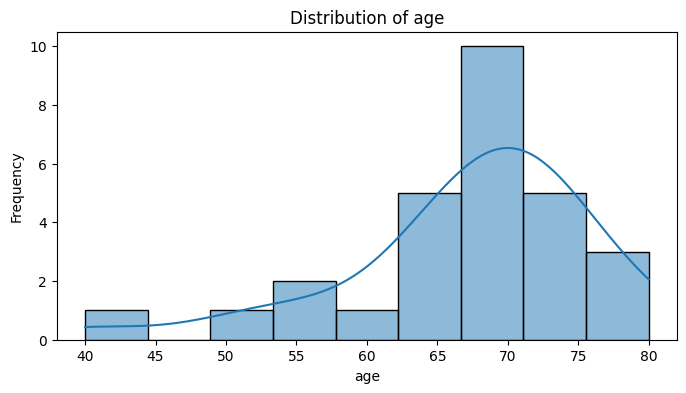

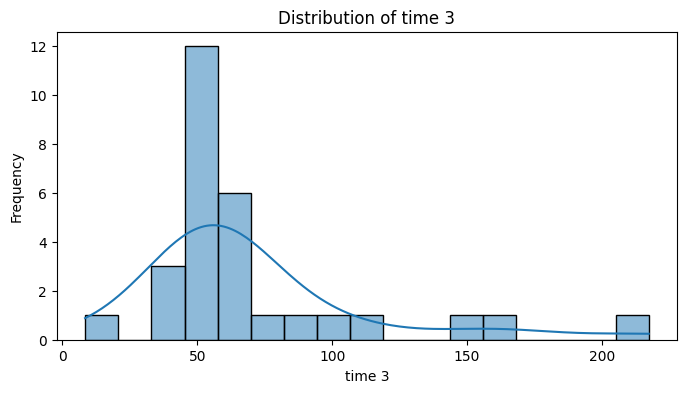

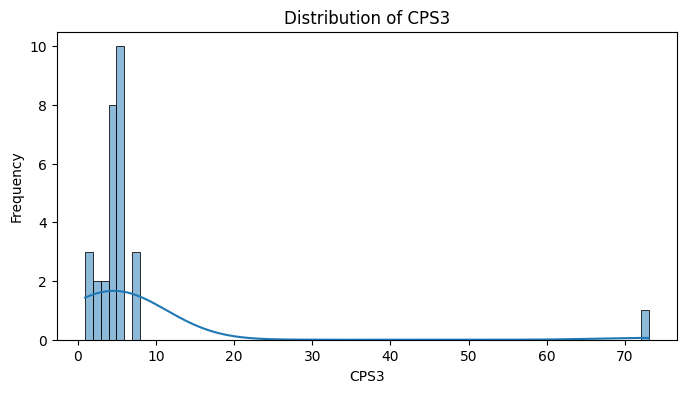

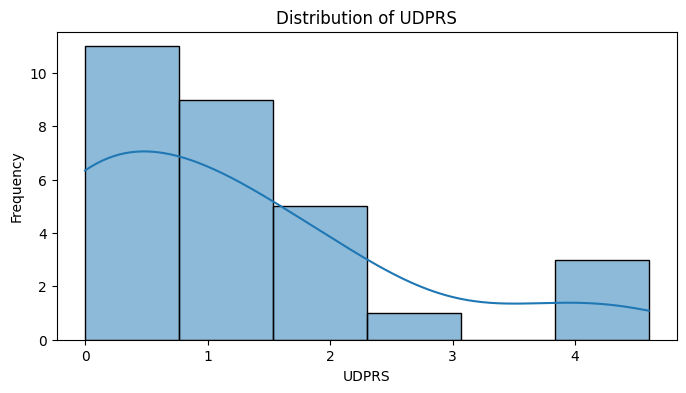

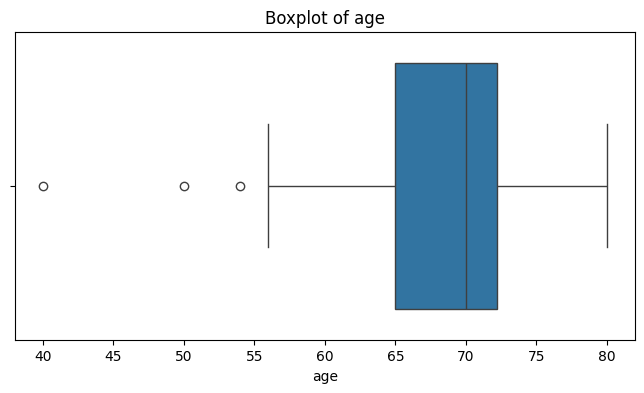

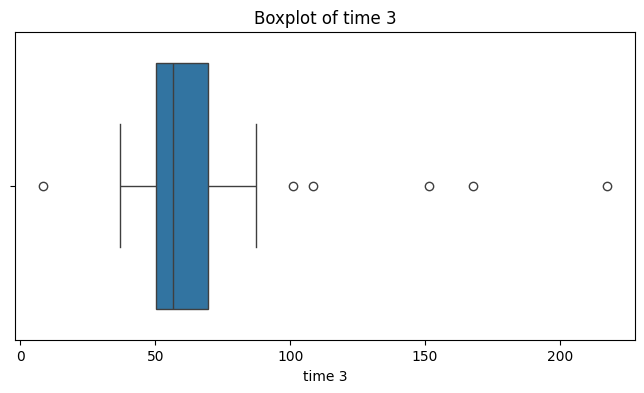

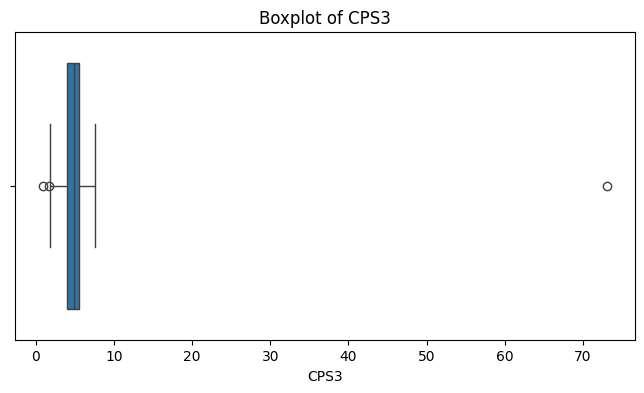

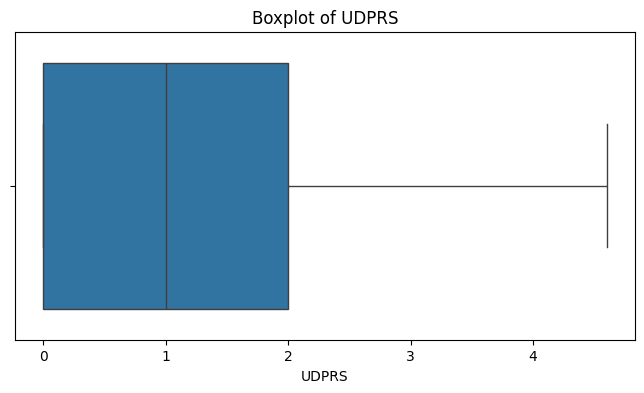

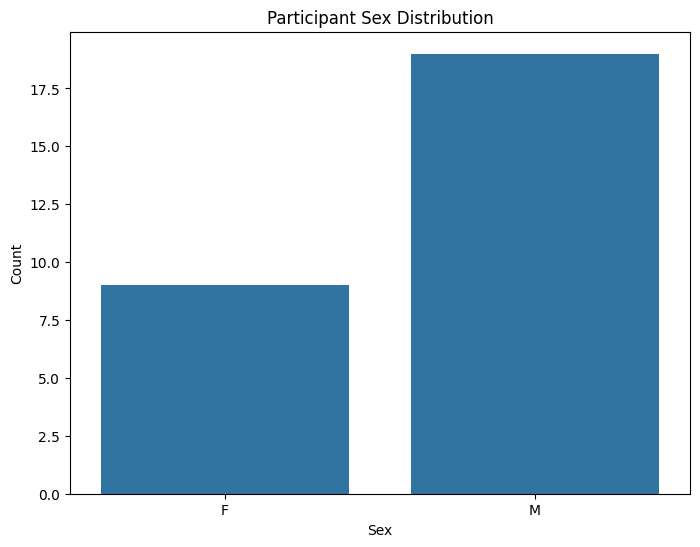

In [50]:
# Load data from Excel file
excel_file = 'data/28 People with PD/TAB 5.xlsx'
patients_data = pd.read_excel(excel_file)

# Printing basic statistics from the data
print("Data Overview:")
print(patients_data.info())

print("\nSummary Statistics:")
print(patients_data.describe())

print("\nMissing Values:")
print(patients_data.isnull().sum())

# Plotting the histograms
numeric_cols = patients_data.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(patients_data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Plotting the boxplots
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=patients_data[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='sex', data=patients_data)
plt.title('Participant Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()


In [3]:
# Code used to extract the features from .wav files
features = []

directory = 'data/data/VU1VU2_pd_data/' 
for file in tqdm(os.listdir(directory)):
    file_name = directory + file
    sampling_rate, signal = audioBasicIO.read_audio_file(file_name)

    # Extract features
    feature, feature_names = ShortTermFeatures.feature_extraction(signal, sampling_rate, 0.050 * sampling_rate, 0.025 * sampling_rate)
    mean_features = np.mean(feature, axis=1)
    features.append(mean_features)
save_to_pickle(features, 'pickles/features_pd_VU1VU2.pkl')

 18%|█▊        | 10/55 [00:06<00:27,  1.65it/s]c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\pyAudioAnalysis\audioBasicIO.py:99: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, signal = wavfile.read(input_file) # from scipy.io
100%|██████████| 55/55 [00:32<00:00,  1.69it/s]

Variable saved to 'pickles/features_pd_VU1VU2.pkl'


In [42]:
def making_model(title, features_subset_df, y):
    # Split the data into training and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(features_subset_df, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

    class TransformerModel(nn.Module):
        def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.1):
            super(TransformerModel, self).__init__()
            # Define the transformer layers
            self.transformer_layers = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=input_dim, nhead=1, dropout=dropout),
                num_layers=num_layers
            )
            # Define hidden layers with batch normalization and dropout
            self.hidden_layers = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout)
            )
            # Output layer for regression
            self.output_layer = nn.Linear(hidden_dim, 1)
        
        def forward(self, x):
            # Pass input through transformer layers
            x = self.transformer_layers(x)
            # Apply hidden layers
            x = self.hidden_layers(x)
            # Apply output layer for regression
            x = self.output_layer(x)
            return x.squeeze()

    # Convert to PyTorch tensors 
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create DataLoaders
    batch_size = 32  # You can adjust the batch size as needed

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model, loss function, and optimizer
    input_dim = X_train.shape[1]
    model = TransformerModel(input_dim=input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.2)

    # Training loop
    epochs = 50
    train_losses = []  # Store training loss for plotting
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss/len(train_loader))  # Append the average training loss per epoch

    # Evaluation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    print(f"Test Loss: {test_loss/len(test_loader)}")

    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).numpy()
        y_pred_test = model(X_test_tensor).numpy()

    # Computing the MAE and MSE
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)

    print(f"Training MAE: {mae_train}")
    print(f"Training MSE: {mse_train}")
    print(f"Testing MAE: {mae_test}")
    print(f"Testing MSE: {mse_test}")

    # Plotting the loss curve during training
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve of the ' + title)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Convert predictions to binary classes based on a threshold
    threshold = 0.5
    y_pred_train_class = (y_pred_train > threshold).astype(int)
    y_pred_test_class = (y_pred_test > threshold).astype(int)

    y_train_values = y_train.values.ravel()  
    y_test_values = y_test.values.ravel()

    # Calculate the model's accuracy
    accuracy_train = (y_pred_train_class == y_train_values).mean()
    accuracy_test = (y_pred_test_class == y_test_values).mean()

    print(f"Training Accuracy: {accuracy_train}")
    print(f"Testing Accuracy: {accuracy_test}")

    # Making the confusion matrix
    bins = [0, 1, 2, 3, 4]
    y_true_binned = np.digitize(y_test, bins) - 1
    y_pred_binned = np.digitize(y_pred_test, bins) - 1
    
    # Plotting the confusion matrix
    cm = confusion_matrix(y_true_binned, y_pred_binned)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bins)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7])). This will likely lead to incorrect results due to b

Test Loss: 1.7655690908432007
Training MAE: 0.8259529285474655
Training MSE: 1.241696146161033
Testing MAE: 0.9416789132006028
Testing MSE: 1.7655687074997608


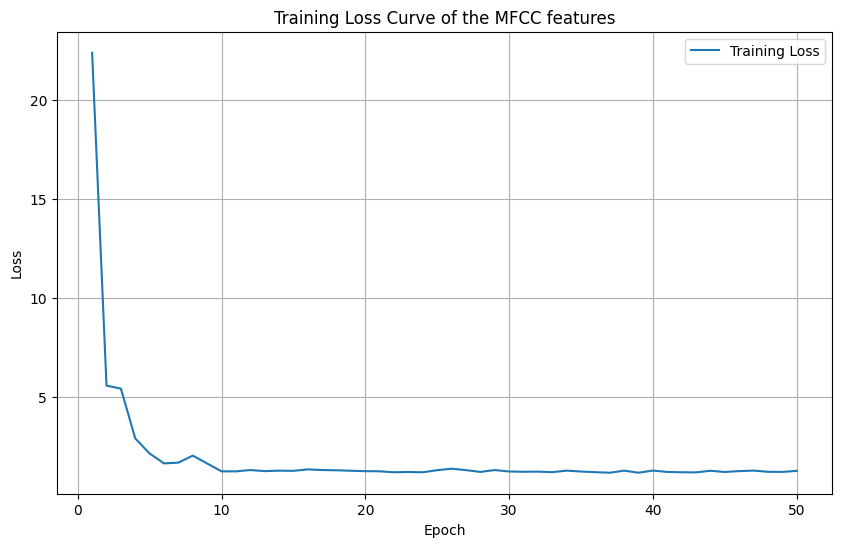

Training Accuracy: 0.3211009174311927
Testing Accuracy: 0.35294117647058826


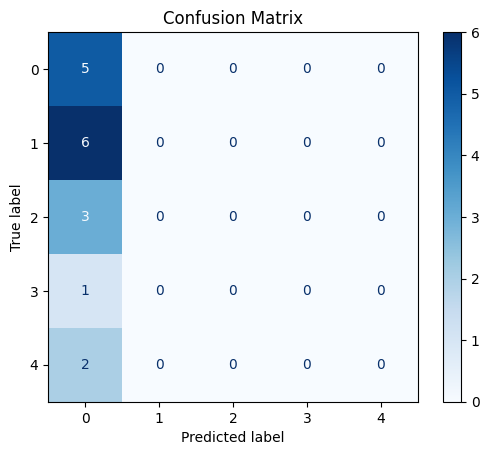

c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7])). This will likely lead to incorrect results due to b

Test Loss: 1.750441074371338
Training MAE: 0.8345393398121592
Training MSE: 1.2402408126260152
Testing MAE: 0.9473008127773509
Testing MSE: 1.7504410485764665


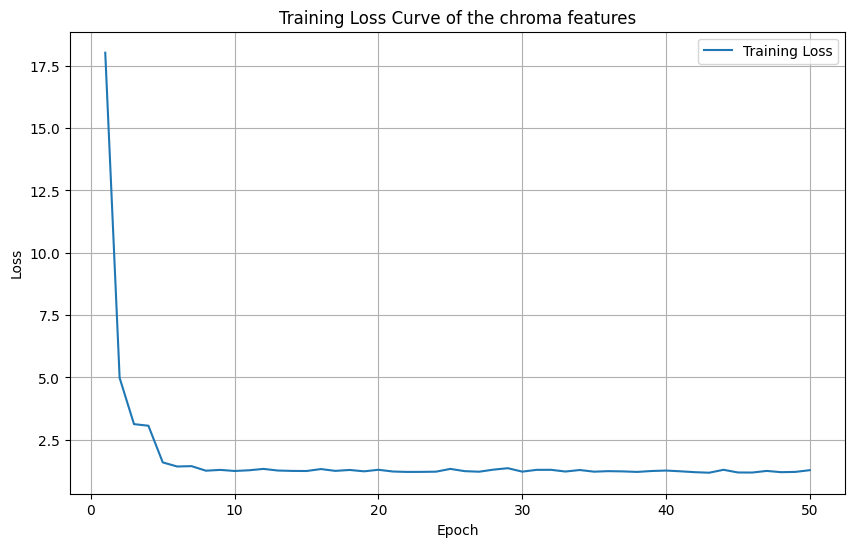

Training Accuracy: 0.3211009174311927
Testing Accuracy: 0.35294117647058826


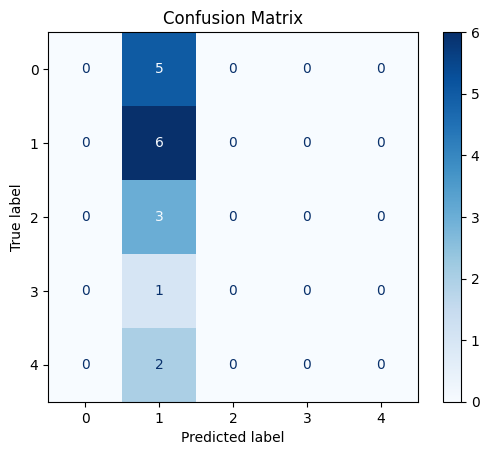

c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7])). This will likely lead to incorrect results due to b

Test Loss: 1.7293387651443481
Training MAE: 0.8487598731977131
Training MSE: 1.239888630895641
Testing MAE: 0.9571402423522052
Testing MSE: 1.729338803742669


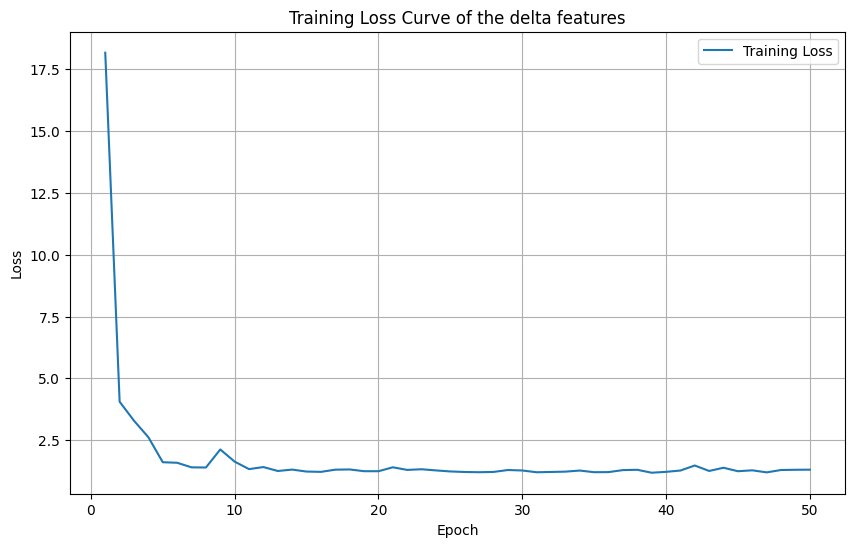

Training Accuracy: 0.3211009174311927
Testing Accuracy: 0.35294117647058826


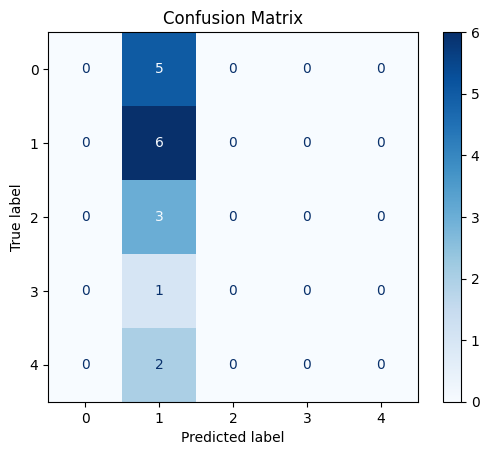

c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7])). This will likely lead to incorrect results due to b

Test Loss: 1.7259573936462402
Training MAE: 0.8511893257088617
Training MSE: 1.2400523462762019
Testing MAE: 0.9588212335810942
Testing MSE: 1.7259575145320971


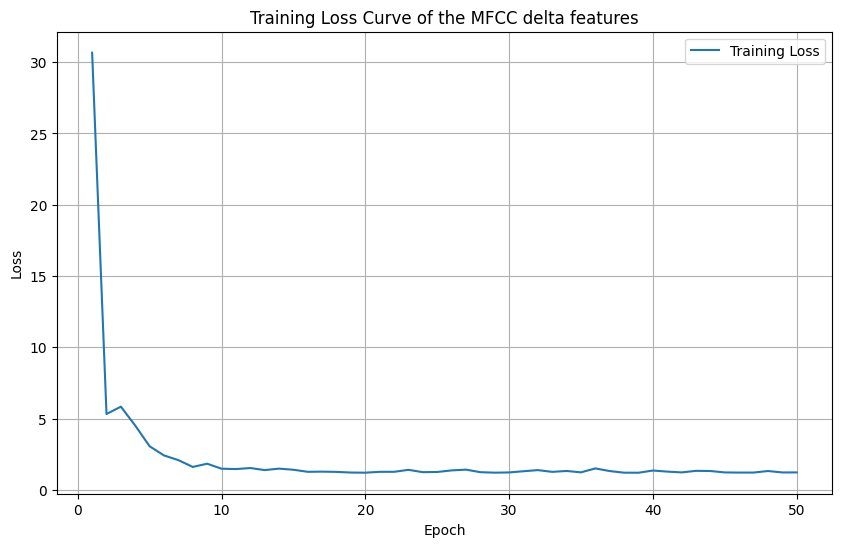

Training Accuracy: 0.3211009174311927
Testing Accuracy: 0.35294117647058826


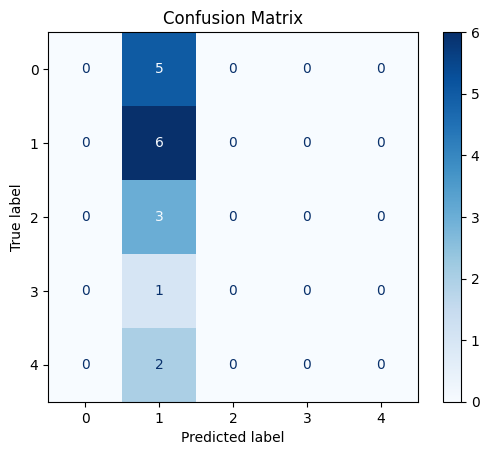

c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Pien\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7])). This will likely lead to incorrect results due to b

Test Loss: 1.7004797458648682
Training MAE: 0.8712971611489578
Training MSE: 1.2439152376093343
Testing MAE: 0.9727341708014993
Testing MSE: 1.7004798458031938


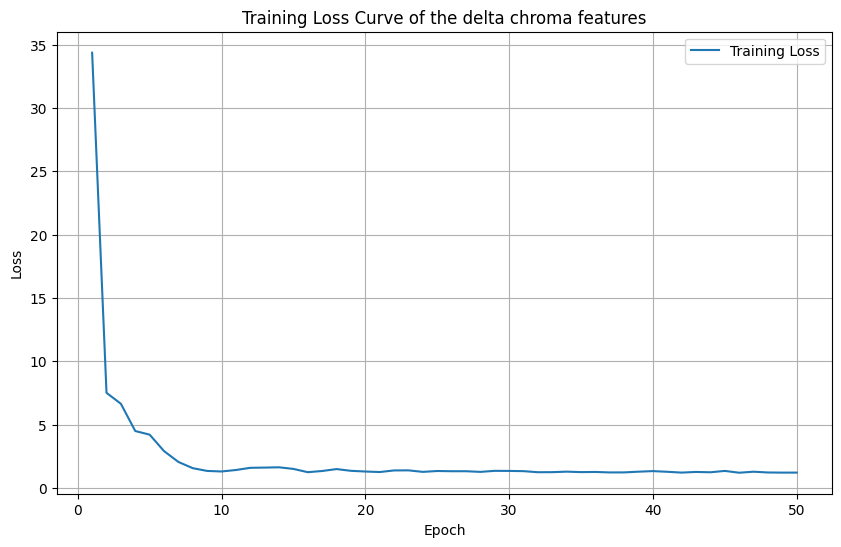

Training Accuracy: 0.3211009174311927
Testing Accuracy: 0.35294117647058826


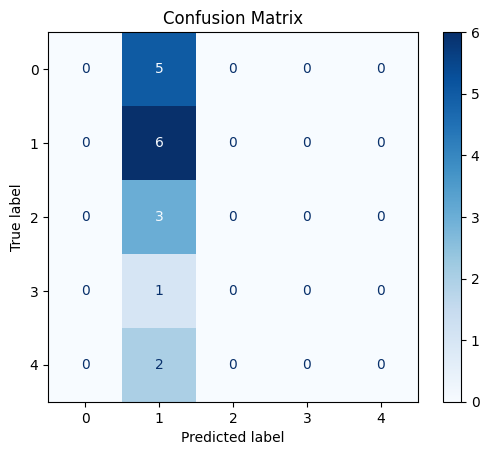

In [43]:
# Extracting the pickle files which hold the features
feature_names = import_from_pickle('/pickles/feature_names.pkl')
features_b1_b2 = import_from_pickle('/pickles/features_pd.pkl')
features_d1_d2 = import_from_pickle('/pickles/features_pd_D1D2.pkl')
features_fb1 = import_from_pickle('/pickles/features_pd_FB1FB2.pkl')
features_va1_va2 = import_from_pickle('/pickles/features_pd_VA1VA2.pkl')
features_ve1_ve2 = import_from_pickle('/pickles/features_pd_VE1VE2.pkl')
features_vi1_vi2 = import_from_pickle('/pickles/features_pd_VI1VI2.pkl')
features_vo1_vo2 = import_from_pickle('/pickles/features_pd_VO1VO2.pkl')
features_vu1_vu2 = import_from_pickle('/pickles/features_pd_VU1VU2.pkl')

def make_dataframe(features, feature_names):
    df = pd.DataFrame(features, columns=feature_names)
    return df

# Create dataframes for each feature set
df_b1_b2 = make_dataframe(features_b1_b2, feature_names)
df_d1_d2 = make_dataframe(features_d1_d2, feature_names)
df_fb1 = make_dataframe(features_fb1, feature_names)
df_va1_va2 = make_dataframe(features_va1_va2, feature_names)
df_ve1_ve2 = make_dataframe(features_ve1_ve2, feature_names)
df_vi1_vi2 = make_dataframe(features_vi1_vi2, feature_names)
df_vo1_vo2 = make_dataframe(features_vo1_vo2, feature_names)
df_vu1_vu2 = make_dataframe(features_vu1_vu2, feature_names)

# Concatenate dataframes
features = pd.concat([df_b1_b2, df_d1_d2, df_fb1, df_va1_va2, df_ve1_ve2, df_vi1_vi2, df_vo1_vo2, df_vu1_vu2])

# Each speech task has its own unique UDPRS score
UPDRS = [1,2,2,0,1,1,0,3,0,0,1,1,1,0,4,4,1,2,0,2,2,1,0,1,0,0,0,0]

UPDRS_B1_B2 = [1,2,2,0,1,1,0,3,0,0,1,1,1,0,4,4,1,2,0,2,2,1,0,1,0,0,0,0,
        1,2,2,0,1,0,0,0,1,1,1,0,1,2,0,2,2,1,0,1,0,0,0,0]
UPDRS_D1_D2 = UPDRS + UPDRS
UPDRS_FB1 = [1,2,2,0,1,1,0,3,0,0,1,1,1,0,1,2,0,2,2,1,0,1,0,0,0,0]
UPDRS_VA1_VA2 = UPDRS + [1,2,2,0,1,1,0,0,0,1,1,1,0,4,4,1,2,0,2,2,1,0,1,0,0,0,0]
UPDRS_VE1_VE2 = UPDRS_VA1_VA2
UPDRS_VI1_VI2 = UPDRS_VA1_VA2
UPDRS_VO1_VO2 = UPDRS_VA1_VA2
UPDRS_VU1_VU2 = UPDRS_VA1_VA2

# Concatenate all lists
UPDRS = UPDRS_B1_B2 + UPDRS_D1_D2 + UPDRS_FB1 + UPDRS_VA1_VA2 + UPDRS_VE1_VE2 + UPDRS_VI1_VI2 + UPDRS_VO1_VO2 + UPDRS_VU1_VU2

y = pd.DataFrame(UPDRS)

# Select a subset of features
all_feature_names = ['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'chroma_std', 'delta zcr', 'delta energy', 'delta energy_entropy', 'delta spectral_centroid', 'delta spectral_spread', 'delta spectral_entropy', 'delta spectral_flux', 'delta spectral_rolloff', 'delta mfcc_1', 'delta mfcc_2', 'delta mfcc_3', 'delta mfcc_4', 'delta mfcc_5', 'delta mfcc_6', 'delta mfcc_7', 'delta mfcc_8', 'delta mfcc_9', 'delta mfcc_10', 'delta mfcc_11', 'delta mfcc_12', 'delta mfcc_13', 'delta chroma_1', 'delta chroma_2', 'delta chroma_3', 'delta chroma_4', 'delta chroma_5', 'delta chroma_6', 'delta chroma_7', 'delta chroma_8', 'delta chroma_9', 'delta chroma_10', 'delta chroma_11']  # Example subset
subset_feature_names = []
mfcc_feature_names = []
delta_feature_names = []
delta_mfcc_feature_names = []
delta_chroma_feature_names = []
chroma_feature_names = []

for feature in feature_names:
    if 'mfcc' in feature and 'delta' not in feature and 'chroma' not in feature:
        mfcc_feature_names.append(feature)
    if 'delta' in feature:
        if 'chroma' in feature or 'mfcc' in feature: 
            delta_feature_names.append(feature)
    if 'delta' in feature and 'mfcc' in feature: 
        delta_mfcc_feature_names.append(feature)
    if 'delta' in feature and 'chroma' in feature: 
        delta_chroma_feature_names.append(feature)
    if 'chroma' in feature and 'delta' not in feature and 'mfcc' not in feature:
        chroma_feature_names.append(feature)

# Training the models for each of the features
making_model("MFCC features", features[mfcc_feature_names], y)
making_model("chroma features", features[chroma_feature_names], y)
making_model("delta features", features[delta_feature_names], y)
making_model("MFCC delta features", features[delta_mfcc_feature_names], y)
making_model("delta chroma features", features[delta_chroma_feature_names], y)